<a href="https://colab.research.google.com/github/Indranil-Sarkar/twitter-sntiment-analysis/blob/main/Final_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Embedding, Dense, GlobalMaxPool1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [8]:
df = pd.read_csv("/content/Tweets.csv")

In [9]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


#  Data Preprocessing

In [10]:
df.isnull().sum() #Check for null values

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [11]:
df = df.dropna() # drop nan values

In [12]:
df.shape

(27480, 4)

In [13]:
# check for duplicated data
df.duplicated().sum()

0

In [14]:
df = df.reset_index(drop = True)
df.tail()

,textID,text,selected_text,sentiment
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive
27479,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral


In [15]:
#convert label string to numerical categories

df['labelId'] = df['sentiment'].factorize()[0]
catId = df[['sentiment', 'labelId']].drop_duplicates().sort_values('labelId')
catToId = dict(catId.values)
idToCat = dict(catId[['labelId', 'sentiment']].values)


idToCat

{0: 'neutral', 1: 'negative', 2: 'positive'}

In [16]:
#Printing the data
text = df['selected_text'].values
label = df['labelId'].values

for i in range(10552,10559):
    print('Text: ', text[i])
    print('Label:', label[i],"\n")

Text:  bali!! can wait for it
Label: 0 

Text:  glad
Label: 2 

Text:  I gots a Pandora bracelet for my birthdaaaay
Label: 0 

Text:  Tis the best
Label: 2 

Text:  i feel like watching a disney movie...too bad we dont have a vcr anymore
Label: 1 

Text:  my last full week of school!
Label: 0 

Text:  Sadly, many people in the quilt pics are now laid off.
Label: 1 



# EDA

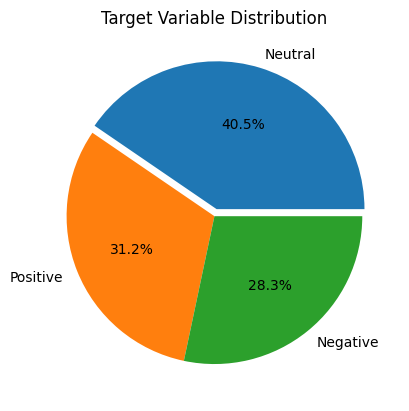

In [17]:
plt.title('Target Variable Distribution')
plt.pie(df['sentiment'].value_counts(), labels=['Neutral','Positive','Negative'],explode=[0.05,0,0], autopct='%1.1f%%')
plt.show()
#Neutral is much higher compared to Negative

In [18]:
neut_df = df[df['sentiment']=='neutral']['text']
pos_df = df[df['sentiment']=='positive']['text']
neg_df = df[df['sentiment']== 'negative']['text']

In [19]:
def freq_text(text_df):
    combi_text=""
    for x in text_df.values:
        combi_text+=' '.join(x.split())
    combi_text  = [x for x in combi_text.split() if len(x) >3 and x not in stopwords.words('english')]
    return combi_text

In [20]:
def freq_df(text_count_df,senti):
    fredis = nltk.FreqDist(neut_text)
    fredis_df = pd.DataFrame({senti: list(fredis.keys()),
                      'Count': list(fredis.values())})
    fredis_df = fredis_df.sort_values(by='Count',ascending=False)
    return fredis_df

In [21]:
def plot_freq_dis(text_count_df,senti):
    sns.barplot(data=text_count_df[:10],x=senti,y='Count')

In [22]:
neut_df.shape

(11117,)

In [23]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

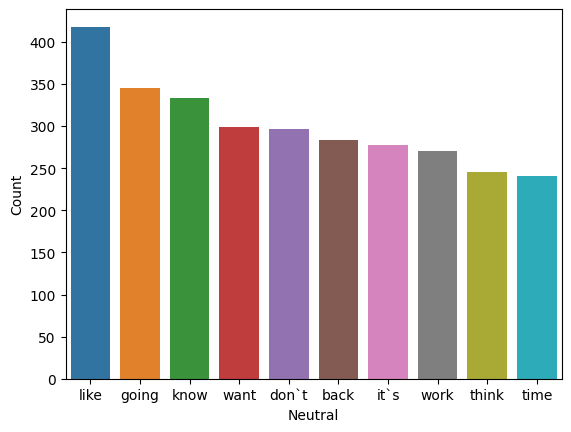

In [24]:
senti ='Neutral'
neut_text = freq_text(neut_df)
neut_frq_df = freq_df(neut_text,senti)
plot_freq_dis(neut_frq_df,senti)

In [25]:
def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

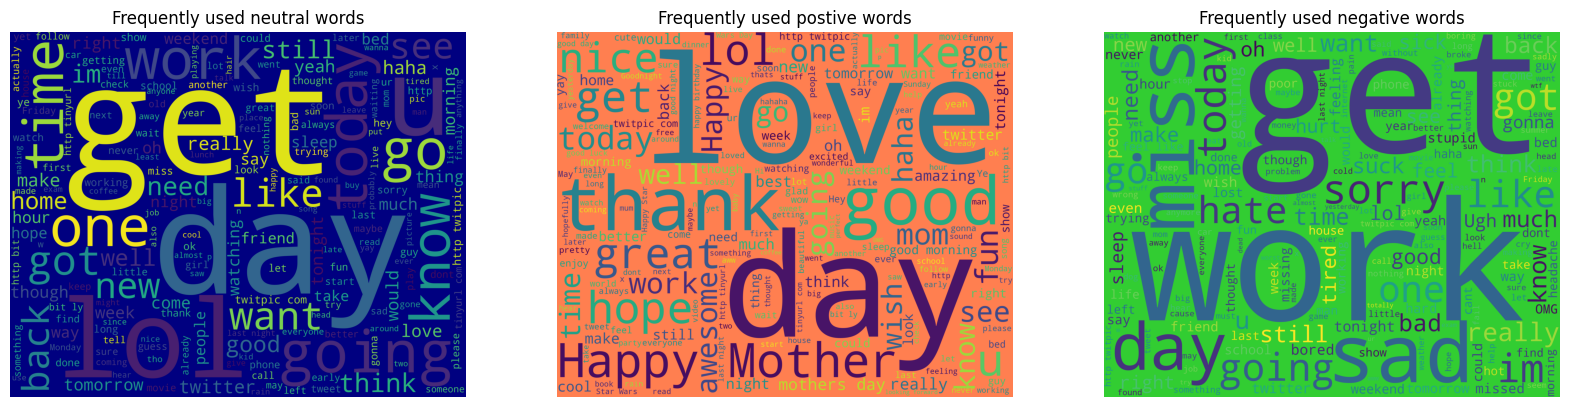

In [26]:
plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
wordcloud_draw(neut_df,'navy','Frequently used neutral words')
plt.subplot(1,3,2)
wordcloud_draw(pos_df,'coral','Frequently used postive words')
plt.subplot(1,3,3)
wordcloud_draw(neg_df, 'limegreen','Frequently used negative words')
plt.show()

# Model Training

In [27]:
#max features
maxfeatures = 10000

#tokenization
tokenizer = Tokenizer(num_words = maxfeatures)
tokenizer.fit_on_texts(text)

In [28]:
tokenizer.word_index

{'i': 1,
 'to': 2,
 'the': 3,
 'a': 4,
 'you': 5,
 'it': 6,
 'my': 7,
 'and': 8,
 'is': 9,
 's': 10,
 'in': 11,
 't': 12,
 'for': 13,
 'of': 14,
 'me': 15,
 'that': 16,
 'on': 17,
 'so': 18,
 'have': 19,
 'but': 20,
 'm': 21,
 'good': 22,
 'not': 23,
 'just': 24,
 'be': 25,
 'day': 26,
 'with': 27,
 'at': 28,
 'was': 29,
 'love': 30,
 'can': 31,
 'happy': 32,
 'no': 33,
 'all': 34,
 'this': 35,
 'up': 36,
 'now': 37,
 'out': 38,
 'get': 39,
 'like': 40,
 'are': 41,
 'go': 42,
 'do': 43,
 'work': 44,
 'too': 45,
 'going': 46,
 'your': 47,
 'today': 48,
 'lol': 49,
 'what': 50,
 'got': 51,
 'don': 52,
 'we': 53,
 'one': 54,
 'time': 55,
 'thanks': 56,
 'u': 57,
 'miss': 58,
 'really': 59,
 'will': 60,
 'back': 61,
 'know': 62,
 'from': 63,
 'im': 64,
 'there': 65,
 'great': 66,
 'fun': 67,
 'see': 68,
 'its': 69,
 'am': 70,
 'sad': 71,
 'sorry': 72,
 'if': 73,
 'some': 74,
 'well': 75,
 'home': 76,
 'want': 77,
 'about': 78,
 'they': 79,
 'hope': 80,
 'had': 81,
 'bad': 82,
 'night': 83,

In [29]:
#max sequential length of a tweet
maxseqlen = max([len(i.split()) for i in text])
print(maxseqlen)

33


In [30]:
X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, maxseqlen)
y = to_categorical(label, num_classes = 3)

print("Shape of data tensor ['text']:", X.shape)
print("Shape of data tensor ['label']:", y.shape)

Shape of data tensor ['text']: (27480, 33)
Shape of data tensor ['label']: (27480, 3)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(21984, 33) (21984, 3)
(5496, 33) (5496, 3)


In [32]:
X_train

array([[   0,    0,    0, ...,    0,    0,  981],
       [   0,    0,    0, ...,   27, 4306,    5],
       [   0,    0,    0, ...,  787, 1023,  167],
       ...,
       [   0,    0,    0, ...,   28,  546, 1856],
       [   0,    0,    0, ...,    0,    0, 2452],
       [   0,    0,    0, ...,  260,    3,  453]], dtype=int32)

In [33]:
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [34]:
#Neural Network model
model = Sequential()
model.add(Embedding(input_dim = maxfeatures, output_dim = 128, input_length = maxseqlen))
model.add(LSTM(128, return_sequences = True))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))


opt = RMSprop(learning_rate=0.0012, rho=0.7, momentum=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 33, 128)           131584    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                        

In [35]:
#Early Stopping for best result
early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 3)

In [36]:
from datetime import datetime

#training model
start_time = datetime.now()
history = model.fit(X_train, y_train,
                    batch_size = 100, epochs = 15, shuffle = True,
                    validation_split = 0.1, verbose = 1,
                    callbacks=early_stop)
end_time = datetime.now()
print("Time out: {}".format(end_time - start_time))

Epoch 1/15
198/198 [==============================] - 31s 141ms/step - loss: 0.8000 - accuracy: 0.6378 - val_loss: 0.6469 - val_accuracy: 0.7431
Epoch 2/15
198/198 [==============================] - 26s 132ms/step - loss: 0.5205 - accuracy: 0.8062 - val_loss: 0.4809 - val_accuracy: 0.8122
Epoch 3/15
198/198 [==============================] - 27s 136ms/step - loss: 0.3984 - accuracy: 0.8585 - val_loss: 0.4375 - val_accuracy: 0.8336
Epoch 4/15
198/198 [==============================] - 26s 133ms/step - loss: 0.3455 - accuracy: 0.8808 - val_loss: 0.4272 - val_accuracy: 0.8427
Epoch 5/15
198/198 [==============================] - 26s 134ms/step - loss: 0.3056 - accuracy: 0.8955 - val_loss: 0.4433 - val_accuracy: 0.8440
Epoch 6/15
198/198 [==============================] - 26s 132ms/step - loss: 0.2717 - accuracy: 0.9107 - val_loss: 0.4538 - val_accuracy: 0.8404
Epoch 7/15
198/198 [==============================] - 32s 164ms/step - loss: 0.2405 - accuracy: 0.9216 - val_loss: 0.4646 - val_ac

# Model Evaluation

In [37]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_act = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_act, y_pred_class)
print("Accuracy: ",round(accuracy*100,4), "%")

172/172 [==============================] - 4s 20ms/step
Accuracy:  84.1521 %


In [38]:
# generate confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

target = ['Neutral', 'Negative', 'Positive']
print(confusion_matrix(y_act, np.argmax(y_pred, axis=1)))
print(classification_report(y_act, np.argmax(y_pred, axis = 1), target_names = target))

[[1961  178   97]
 [ 235 1276   61]
 [ 208   92 1388]]
              precision    recall  f1-score   support

     Neutral       0.82      0.88      0.85      2236
    Negative       0.83      0.81      0.82      1572
    Positive       0.90      0.82      0.86      1688

    accuracy                           0.84      5496
   macro avg       0.85      0.84      0.84      5496
weighted avg       0.84      0.84      0.84      5496



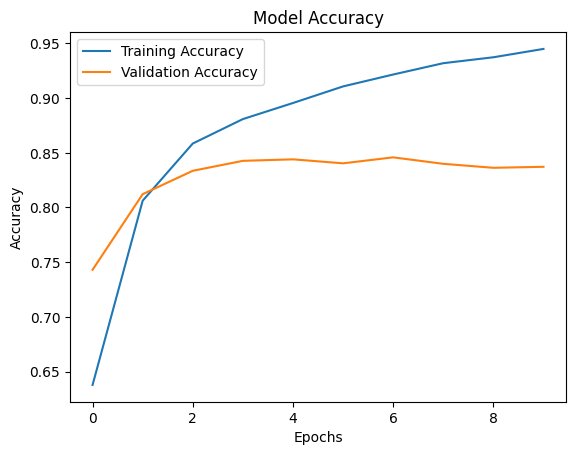

In [39]:
import matplotlib.pyplot as plt

plt.plot (history.history['accuracy'])
plt.plot (history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

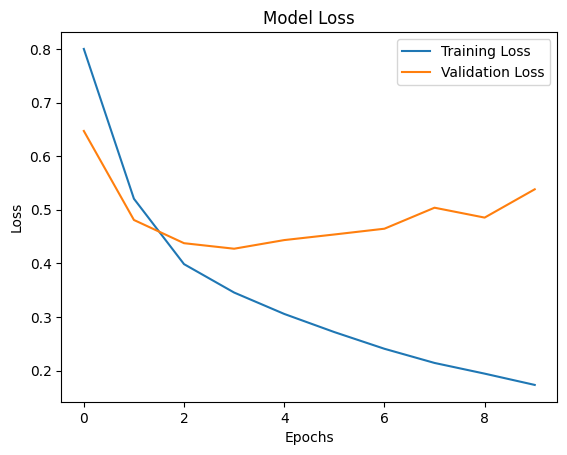

In [40]:
import matplotlib.pyplot as plt

plt.plot (history.history['loss'])
plt.plot (history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

# Sentiment for User Input

In [41]:
#inp = np.array(["Happy birthday.. Have a great day"])
inp = np.array(["I hate you. I am really sad..."])
#inp = np.array(["haha! you get home today"])
inp = tokenizer.texts_to_sequences(inp)
inp = pad_sequences(inp, maxseqlen)
inp = inp[0].reshape(1,33)

In [42]:
result = model.predict(inp, verbose=0)
ind = np.argmax(result)
sentiment = ""
if ind==0:
    sentiment = "Neutral"
elif ind==1:
    sentiment = "Negative"
elif ind==2:
    sentiment = "Positive"

print("Sentiment: ",sentiment)

Sentiment:  Negative


In [43]:
def prediction_gui(inpt):
  inpt= np.array([inpt])
  inpt = tokenizer.texts_to_sequences(inpt)
  inpt = pad_sequences(inpt, maxseqlen)
  inpt = inpt[0].reshape(1,33)
  result = model.predict(inpt, verbose=0)
  ind1 = np.argmax(result)
  sentiment = ""
  if ind1==0:
    sentiment = "Neutral"
  elif ind1==1:
    sentiment = "Negative"
  elif ind1==2:
    sentiment = "Positive"

  return  sentiment

In [ ]:
! pip install gradio

In [45]:
import gradio as gr

In [46]:
with gr.Blocks() as demo:
    name = gr.Textbox(label="Tweets", placeholder="Enter the tweet for prediction...",lines = 2)
    output = gr.Textbox(label="Sentiment :")
    greet_btn = gr.Button("Predict!")
    greet_btn.click(fn=prediction_gui, inputs=name, outputs=output)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a841fdc0f4af9f9d36.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
